# Wine Quality Prediction Using Decistion Trees Algorithm

## Importing Libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Setting up Style

In [32]:
# Set a style for better visualizations
sns.set_style("whitegrid")

## Data Loading and Initial Exploration

###### Insight: The first step is to load the data and understand its basic structure.
###### This initial look helps us identify the features, the target variable, and any
###### potential issues like missing values or incorrect data types.

In [33]:
# Load the dataset from the CSV file
df = pd.read_csv("winequality-red.csv")

In [34]:
print("--- Initial Data Overview ---")
print("First 5 rows of the dataset:")
print(df.head())

--- Initial Data Overview ---
First 5 rows of the dataset:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0    

In [35]:
print("\n--- Dataset Information ---")
df.info()


--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [36]:
print("\n--- Descriptive Statistics ---")
print(df.describe().T)


--- Descriptive Statistics ---
                       count       mean        std      min      25%  \
fixed acidity         1599.0   8.319637   1.741096  4.60000   7.1000   
volatile acidity      1599.0   0.527821   0.179060  0.12000   0.3900   
citric acid           1599.0   0.270976   0.194801  0.00000   0.0900   
residual sugar        1599.0   2.538806   1.409928  0.90000   1.9000   
chlorides             1599.0   0.087467   0.047065  0.01200   0.0700   
free sulfur dioxide   1599.0  15.874922  10.460157  1.00000   7.0000   
total sulfur dioxide  1599.0  46.467792  32.895324  6.00000  22.0000   
density               1599.0   0.996747   0.001887  0.99007   0.9956   
pH                    1599.0   3.311113   0.154386  2.74000   3.2100   
sulphates             1599.0   0.658149   0.169507  0.33000   0.5500   
alcohol               1599.0  10.422983   1.065668  8.40000   9.5000   
quality               1599.0   5.636023   0.807569  3.00000   5.0000   

                           50% 

###### Insight: The dataset has 11 features (e.g., 'fixed acidity', 'pH') and one target
###### variable, 'quality', which is a rating from 3 to 8. This is a multi-class
###### classification problem, but for simplicity and better model performance,
###### we will convert it into a binary classification problem: good wine vs. bad wine.
###### We will define a "good" wine as having a quality score of 7 or higher. 

## Exploratory Data Analysis (EDA) and Data Preprocessing

###### Insight: Before we build a model, we need to preprocess our data and
###### explore the relationships between features and our target.

In [37]:
# Check for missing values - fortunately, this dataset is clean.
print("\n--- Missing Values Check ---")
print(df.isnull().sum())


--- Missing Values Check ---
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [38]:
# Create the binary target variable: 1 for good quality, 0 for bad quality
# A common practice is to consider a rating of 7 or higher as "good".
df['quality_label'] = df['quality'].apply(lambda x: 1 if x >= 7 else 0)

In [39]:
print("\n--- New Target Variable Distribution ---")
print(df['quality_label'].value_counts())


--- New Target Variable Distribution ---
quality_label
0    1382
1     217
Name: count, dtype: int64


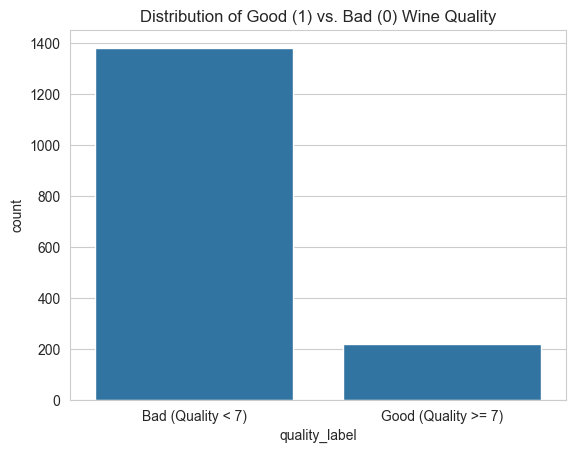

In [40]:
# Visualize the distribution of the new target variable
sns.countplot(x='quality_label', data=df)
plt.title('Distribution of Good (1) vs. Bad (0) Wine Quality')
plt.xticks(ticks=[0, 1], labels=['Bad (Quality < 7)', 'Good (Quality >= 7)'])
plt.show()

###### Insight: The class distribution is imbalanced, with far more "bad" wines
###### than "good" ones. This is important to remember when evaluating our model,
###### as a high accuracy might be misleading. We should pay close attention to
###### precision and recall for the minority class.

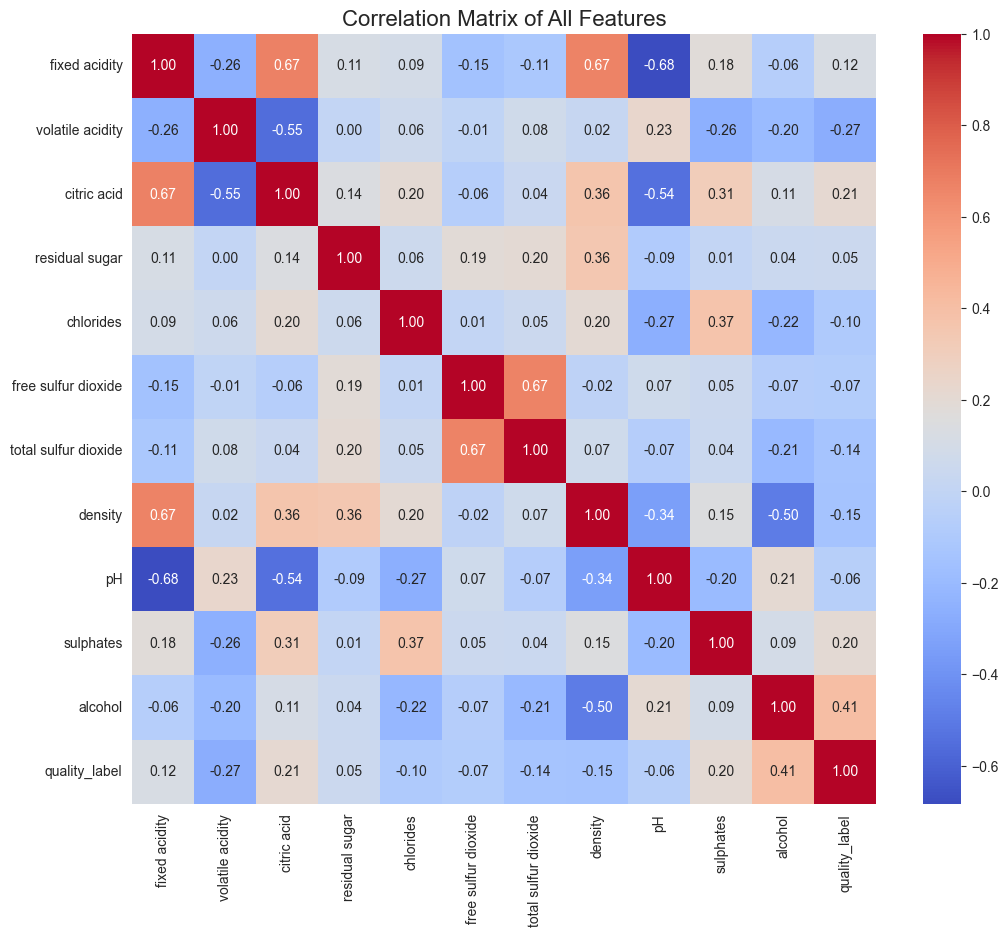

In [41]:
# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.drop('quality', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of All Features', fontsize=16)
plt.show()

###### Insight: The heatmap shows some strong correlations, for example, between
###### 'alcohol' and 'quality'. This suggests that 'alcohol' is a strong predictor.
###### Decision Trees are less sensitive to multicollinearity compared to linear models,
###### so we don't need to perform VIF analysis here, but the insight is still valuable.

## Feature Scaling

###### Insight: Decision Trees are not scale-dependent because they make decisions
###### based on thresholds, not the magnitude of features. However, we'll still
###### standardize the data. This is a good practice for consistency and allows us
###### to easily switch to other algorithms (e.g., SVMs or Logistic Regression)
###### that are sensitive to feature scaling.

In [42]:
# Separate features (X) and target (y)
X = df.drop(['quality', 'quality_label'], axis=1)
y = df['quality_label']

In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\n--- Scaled Features (First 5 rows) ---")
print(X_scaled_df.head())

## Decision Tree Model Building and Evaluation

###### Insight: Decision Trees work by recursively partitioning the data into subsets
###### based on the values of the features. The algorithm chooses the best split at each
###### step to maximize the separation between the classes. The quality of a split is
###### measured by 'criterion', which is typically Gini impurity or entropy.

###### Mathematical Intuition (Gini Impurity):
###### Gini impurity measures the probability of incorrectly classifying a randomly
###### chosen element in a dataset. A value of 0 means the set is perfectly pure
###### (all elements belong to the same class). The formula for a dataset with J classes is:
###### $G = 1 - \sum_{j=1}^{J} p_j^2$
###### where $p_j$ is the proportion of elements with class $j$. The Decision Tree
###### chooses the split that results in the greatest decrease in Gini impurity.

In [44]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42, stratify=y)
print("\n--- Data Splitting ---")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


--- Data Splitting ---
Training data shape: (1279, 11)
Testing data shape: (320, 11)


In [45]:
# Initialize and train the Decision Tree model
# We'll use a default model first to see its raw performance.
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [46]:
# Make predictions on the test set
y_pred = dt_model.predict(X_test)

In [47]:
# Evaluate the initial model
accuracy = accuracy_score(y_test, y_pred)
print("\n--- Initial Model Performance ---")
print(f"Accuracy: {accuracy:.4f}")


--- Initial Model Performance ---
Accuracy: 0.9031


In [48]:
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       277
           1       0.62      0.70      0.66        43

    accuracy                           0.90       320
   macro avg       0.79      0.82      0.80       320
weighted avg       0.91      0.90      0.91       320




--- Confusion Matrix ---


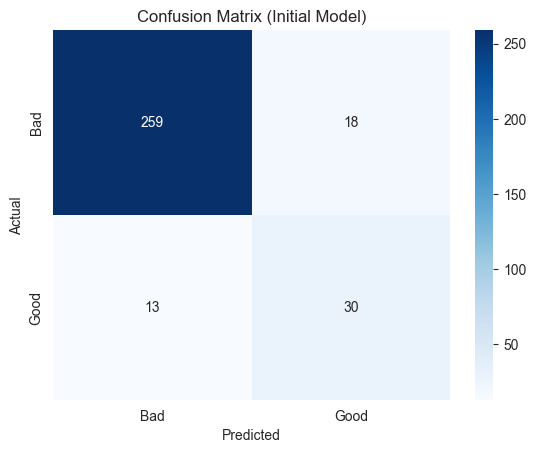

In [49]:
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Initial Model)')
plt.show()

## Hyperparameter Tuning

###### Insight: A Decision Tree can grow to be very complex and deep, leading to
###### overfitting on the training data. This means it memorizes the training data
###### instead of learning general patterns, and performs poorly on unseen data.
###### Hyperparameters like 'max_depth' and 'min_samples_leaf' are used to control this
###### complexity and prevent overfitting. We'll use GridSearchCV to find the optimal
###### combination of these parameters.

In [50]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

In [51]:
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [52]:
best_dt_model = grid_search.best_estimator_
best_params = grid_search.best_params_

In [53]:
print("\n--- Hyperparameter Tuning Results ---")
print(f"Best parameters found: {best_params}")


--- Hyperparameter Tuning Results ---
Best parameters found: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 2}


## Final Model Evaluation and Visualization

###### Insight: Now we'll use our optimized model to make predictions and evaluate
###### its final performance. We will also visualize the tree, which is a key advantage
###### of this algorithm, allowing us to see exactly how it makes its predictions.

In [54]:
y_pred_tuned = best_dt_model.predict(X_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print("accuracy:", accuracy_tuned)

accuracy: 0.909375


In [55]:
print("\n--- Final Tuned Model Performance ---")
print(f"Accuracy with best parameters: {accuracy_tuned:.4f}")
print("\n--- Classification Report for Tuned Model ---")
print(classification_report(y_test, y_pred_tuned))


--- Final Tuned Model Performance ---
Accuracy with best parameters: 0.9094

--- Classification Report for Tuned Model ---
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       277
           1       0.69      0.58      0.63        43

    accuracy                           0.91       320
   macro avg       0.82      0.77      0.79       320
weighted avg       0.90      0.91      0.91       320




--- Confusion Matrix for Tuned Model ---


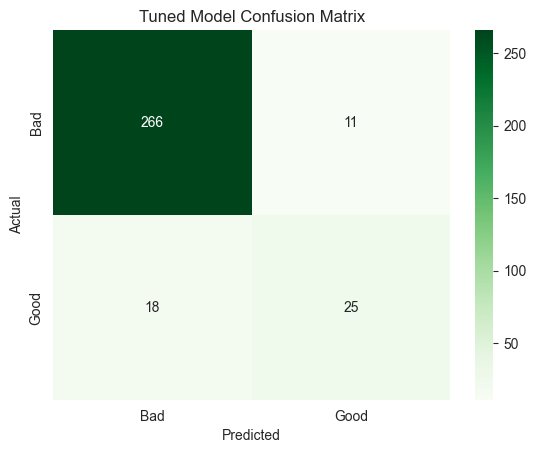

In [56]:
print("\n--- Confusion Matrix for Tuned Model ---")
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens', xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Tuned Model Confusion Matrix')
plt.show()

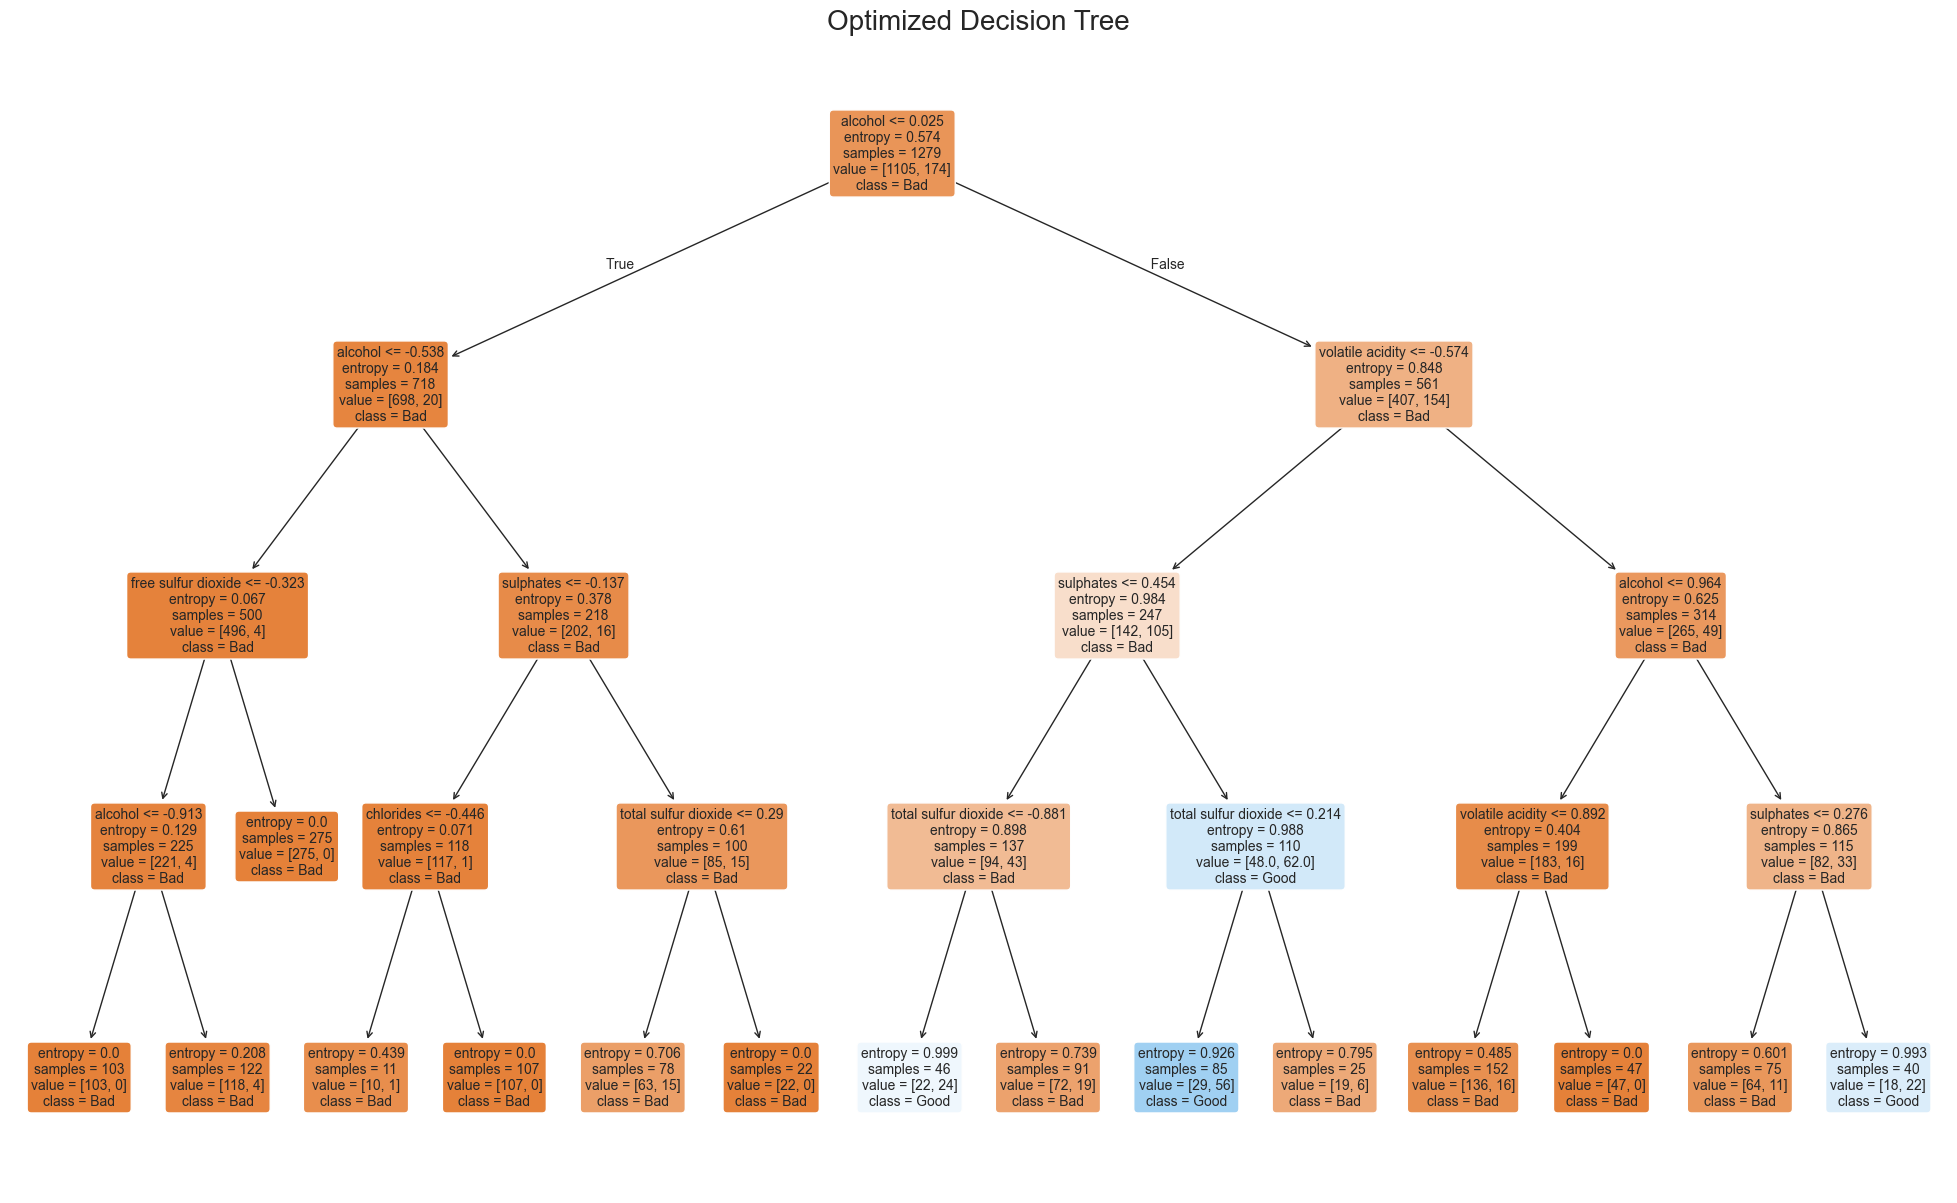

In [57]:
# Visualize the final Decision Tree
plt.figure(figsize=(25, 15))
plot_tree(best_dt_model,
          feature_names=X_scaled_df.columns,
          class_names=['Bad', 'Good'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Optimized Decision Tree', fontsize=20)
plt.show()

###### Final Insight: The visualization of the tree shows the specific features and thresholds
###### the model uses to make its predictions. You can see which features (like 'alcohol')
###### are considered most important at the top of the tree, and how the model makes
###### decisions down to the leaf nodes. The tuned model provides a good balance
###### between accuracy and preventing overfitting, giving us a robust classifier.